<a href="https://colab.research.google.com/github/NiallJeffrey/post-Newtonian/blob/master/jax_integrator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy as np
from jax import jit
from jax.experimental.ode import odeint
import scipy.integrate as osp_integrate

from jax.config import config
config.update("jax_enable_x64", True)

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print('(GPU is often slower)')

cpu
(GPU is often slower)


In [3]:
@jit
def relative_a_component(r, Gm):
    return -Gm*r* (np.linalg.norm(r)**(-3))

@jit
def relative_dynamics(y,t,Gm):
    r, v = y.reshape((2,2))
    dydt = np.concatenate([v, relative_a_component(r, Gm)])
    return dydt.reshape(-1)

In [4]:
y0 = np.array([-1, 1, .1, 0.5])
Gm_val = 1
tsteps = np.linspace(0, 200, 2000)

In [6]:
%time scipy_result = osp_integrate.odeint(relative_dynamics, y0, tsteps, (Gm_val,), rtol=1e-11)
%time jax_result = odeint(relative_dynamics, np.array(y0), np.array(tsteps), np.array([Gm_val]), rtol=1e-11)

CPU times: user 1.52 s, sys: 979 ms, total: 2.5 s
Wall time: 1.63 s
CPU times: user 537 ms, sys: 13.2 ms, total: 550 ms
Wall time: 553 ms


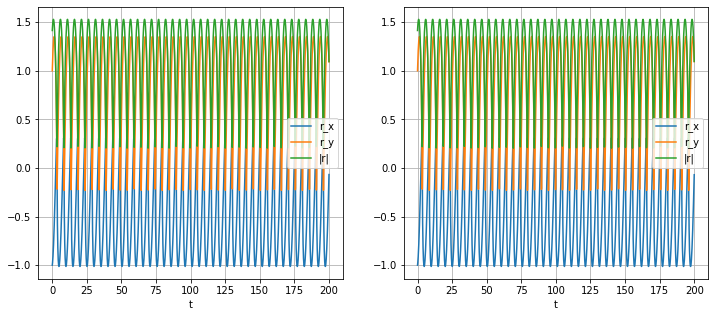

In [7]:
_ = plt.figure(figsize=(12,5)), plt.subplot(1,2,1)
_ = plt.plot(tsteps, scipy_result[:, 0], label='r_x')
_ = plt.plot(tsteps, scipy_result[:, 1], label='r_y')
_ = plt.plot(tsteps, np.sqrt(scipy_result[:, 0]**2.+scipy_result[:, 1]**2.), label='|r|')
_ = plt.legend(loc='best'), plt.xlabel('t'), plt.grid()
_ = plt.subplot(1,2,2), plt.plot(tsteps, jax_result[:, 0], label='r_x')
_ = plt.plot(tsteps, jax_result[:, 1], label='r_y')
_ = plt.plot(tsteps, np.sqrt(jax_result[:, 0]**2.+jax_result[:, 1]**2.), label='|r|')
_ = plt.legend(loc='best'), plt.xlabel('t'), plt.grid()

In [9]:
%time scipy_result_faster = osp_integrate.odeint(relative_dynamics, np.array(y0), np.array(tsteps), (Gm_val,))

%time jax_result_faster = odeint(relative_dynamics, np.array(y0), np.array(tsteps), np.array([Gm_val]))

print('\nMSE error relative to jax low-tolerance')
print('scipy:', np.mean(np.square(jax_result[:, 0] - scipy_result_faster[:, 0])))
print('jax:', np.mean(np.square(jax_result[:, 0] - jax_result_faster[:, 0])))

print('\nMSE error relative to scipy low-tolerance')
print('scipy:', np.mean(np.square(scipy_result[:, 0] - scipy_result_faster[:, 0])))
print('jax:', np.mean(np.square(scipy_result[:, 0] - jax_result_faster[:, 0])))

CPU times: user 1.42 s, sys: 894 ms, total: 2.32 s
Wall time: 1.51 s
CPU times: user 509 ms, sys: 2.3 ms, total: 511 ms
Wall time: 513 ms

MSE error relative to jax low-tolerance
scipy: 2.9034316211694365e-06
jax: 6.541222227960638e-08

MSE error relative to scipy low-tolerance
scipy: 7.231150901654431e-07
jax: 3.5745404812293273e-07


In [10]:
print('Timing scipy')
%timeit osp_integrate.odeint(relative_dynamics, np.array(y0), np.array(tsteps), (Gm_val,))

Timing scipy
1 loop, best of 3: 1.48 s per loop


In [11]:
print('Timing jax')
%timeit odeint(relative_dynamics, np.array(y0), np.array(tsteps), np.array([Gm_val]))

Timing jax
100 loops, best of 3: 2.34 ms per loop
